# PubMed Downloader

This code downloads data from pubmed and stores it in a csv file based on search terms.  PubMed serves as a centralized database to identify most medical studies that exist and can help in identifying relevant research on different topics.

Some information and relevant links include:
- https://www.ncbi.nlm.nih.gov/pmc/tools/developers/
- https://www.nlm.nih.gov/databases/download/data_distrib_main.html
- https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.ESearch 

Author:  Natalie Chun (17 November 2018)

In [21]:
from pubmeddownloader import PubMedDownloader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Download new data

# PubMedDownloader

This class downloads pubmed documents based on key search terms.

In [ ]:
class PubMedDownloader(BaseDownloader):
    """Base class for downloading PubMed Abstracts and Article Names based on key search terms.  
    Currently initialized with key words related to school violence.
    Note:  The downloader stores files in csv with key search term appended.
    """
    
    # pmid is a PubMed ID
    # url is the url of the PubMed web page
    # search_term is the string used in the search box on the PubMed website
    def __init__(self, debug=False):
        self.url = "http://www.ncbi.nlm.nih.gov/pubmed/"
        self.entrezurl = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
        self.date = datetime.datetime.now().strftime('%Y-%m-%d')
        
        # open csv file for search terms
        df = pd.read_csv(os.path.join(FileConfig.RAWDIR, "searchterms.csv"), encoding="ISO-8859-1")
        self.kws = list(set(df['keyword']))
        print("Keyword terms to search: %s" % (self.kws))
    
        self.outdir = os.path.join(FileConfig.EXTDIR, 'pubmed')
        # open the pubmed sql database
        self.conn = sqlite3.connect(os.path.join(self.outdir, 'pubmed.db'))
        self.cursor = self.conn.cursor()
        # create table schema
        self._create_table_schema(get_pubmed_table_schema())
        self.debug=debug

    def graph_searchterms(self):
        """Graph search terms in the database."""
        
        query = """SELECT DISTINCT * FROM searchterms;"""
        df = pd.read_sql(query, self.conn)
        query = """SELECT DISTINCT pmid FROM searchterms;"""
        num_articles = len(pd.read_sql(query, self.conn))
        
        df['cnt'] = 1
        temp = df.groupby(['searchterm'])['cnt'].sum()
        print(temp)
        temp.sort_values(inplace=True)
        ax = temp.plot(kind='barh', figsize=(8, 10), color='blue', zorder=2, width=0.85)
      
        ax.set_xlabel("Counts", labelpad=20, weight='bold', size=12)
        ax.set_ylabel("Search term", labelpad=20, weight='bold', size=12)
        plt.title("No School Violence Articles in PubMed\nTotal unique articles: %s" % (num_articles))
        plt.show()
        
    def search_page(self, searchterm):
        """Get search results from pubmed for particular search term.
        Note:  Only use if the entrez page does not work
        """
        
        url = self.url + '?term=%s&cmd=DetailsSearch' % (searchterm)
        print(url)
        page = urllib.request.urlopen(url)
        parser = BeautifulSoup(page,'html.parser')
        randnum = random.randint(3,10) 
        time.sleep(randnum)
        self.parse_search_page(parser)
        
    def parse_search_page(self, parser):
        """Parses general page of pubmed and insert into database.
        TODO:  Search multiple pages (right now only gets first page)
        need to return
        Note:  No need to use.
        """
        
        data = []
        
        # parse one page of results
        results = parser.find_all('div', {'class':'rslt'})
        for res in results:
            #print(res)
            tempdata = {}
            temp = res.find('p', {'class':'title'})
            print(temp)
            tempdata['title'] = temp.text
            tempdata['href'] = temp.find('a',{'href':True})['href']
            tempdata['desc'] = res.find('p',{'class':'desc'}).text
            temp = res.find('p',{'class':'details'})
            tempdata['jrnl'] = temp.text
            if tempdata['title'] != '':
                cols = []
                for key, value in tempdata.items():
                    cols.append(value.strip('\n'))
                data.append(cols)
                print(data)
        
        with open(self.outdir + 'pubmed-%s.csv' % (self.date), 'w', newline='') as f:
            w = csv.writer(f, delimiter=',')
            w.writerow(['title','href','desc','details'])
            for d in data:
                w.writerow(d)
                
        # get the next page
    
    def search_entrez(self, searchterm, retmax=20):
        """Entrez is the API call that makes it easier to retrieve information from PubMed. 
        Fair use policy entails waiting at least 3 seconds to make a new call.
        """
        print("Downloading: %s" % (searchterm))
        # use keyword term that requires both words to show up in article for it to be relevant
        srch = '{}%5BKYWD%5D'.format(searchterm.replace(' ','%2B'))
        
        url = self.entrezurl + 'esearch.fcgi?db=pubmed&term=%s&retmax=%d' % (srch, retmax)
        page = urllib.request.urlopen(url)
        #print(page)
        parser = BeautifulSoup(page,'html.parser')
        #print(parser)
        ids = parser.find_all('id')
        data = []
        cols = ['PMID', 'PubmedArticleSet', 'PubmedArticle', 'MedlineCitation', 'DateRevised', 
                'Year', 'Month', 'Day', 'Article', 'Journal', 'ISSN', 'JournalIssue', 'PubDate', 
                'Title', 'ISOAbbreviation', 'ArticleTitle', 'ELocationID', 'Abstract', 'AbstractText',
                'AuthorList', 'Author', 'LastName', 'ForeName', 'Initials', 'AffiliationInfo', 'Affiliation', 
                'Language', 'PublicationTypeList', 'PublicationType', 'ArticleDate', 'MedlineJournalInfo',
                'Country', 'MedlineTA', 'NlmUniqueID', 'ISSNLinking', 'PubmedData', 'History', 'PubMedPubDate',
                'Hour', 'Minute', 'PublicationStatus', 'ArticleIdList', 'ArticleId']
  
        # get the new pubmed ids and insert into database
        for i in ids:
            query = """INSERT OR IGNORE INTO searchterms (pmid, searchterm) VALUES (?, ?);""" 
            row = [i.text, searchterm]
            self.cursor.execute(query, row)
        self.conn.commit() 
        
        # query existing pubmed database to get new pubmed articles to insert into database
        query = """SELECT DISTINCT pmid FROM searchterms WHERE pmid NOT IN (SELECT pmid FROM pubmeddata WHERE searchterm == '%s');""" % (searchterm)
        ids = pd.read_sql(query, self.conn)
        query = """SELECT DISTINCT * FROM pubmeddata;"""
        pubmeddata = pd.read_sql(query, self.conn)
        pubmedcols = ','.join(list(pubmeddata.columns))
        valcols = ','.join(['?' for i, col in enumerate(pubmeddata.columns)])
        print("Number of new articles to query for search term %s: %d" % (searchterm, len(ids)))
        
        for cnt, uid in enumerate(ids['pmid']):
            if cnt % 10 == 0:
                print("Number of summaries downloaded: %d" % (cnt))
            tempdata = self.clean_xml_abstract_page(uid)
            coldata = [tempdata[col] if col in tempdata else '' for col in cols]
            query = """INSERT OR IGNORE INTO pubmeddata (%s) VALUES(%s)""" % (pubmedcols, valcols)
            self.cursor.execute(query, coldata)
            self.conn.commit()
            time.sleep(3)
        
    def clean_xml_abstract_page(self, uid):
        """Clean XML node for Entrez abstract page.  These pages provide a fairly complete list of variables
        on each type of publication."""
        
        url = self.entrezurl + 'efetch.fcgi?db=pubmed&id=%s&rettype=abstract&retmode=XML' % (uid)
        page = urllib.request.urlopen(url)
        tree = ET.parse(page)
        root = tree.getroot()
        data = {}
        for elem in root.iter():
            if elem.tag != '':
                if elem.text is not None:
                    if elem.tag in ['ArticleTitle','AbstractText']:
                        data[elem.tag] = elem.text.strip('\n ').encode('ascii','ignore')
                    else:
                        data[elem.tag] = elem.text.strip('\n ')
                    
        #print(data)
        return(data)
        
    def download_entrez_summary(self, uid):
        """This downloads individual entrez summaries based on the UID.
        This page contains easily parsable information, but lacks detail of the abstract page.  
        Therefore this function may not be very useful for collecting data, but could collect certain type 
        of information faster than for the abstract which uses xml parsing."""
        
        url = self.entrezurl + 'esummary.fcgi?db=pubmed&id=%s' % (uid)
        page = urllib.request.urlopen(url)
        #print(page)
        parser = BeautifulSoup(page,'html.parser')
        #print(parser)
        
        # parse the entrez summary
        items = parser.find_all('item')
        data = {}
        data['id'] = uid
        for item in items:
             data[item['name']] = item.text
        time.sleep(3)
        headers = data.keys()
        return(list(headers), list(data.values()))
    
    def run_all_kws(self):
        """Run and download articles for all kws.  Max out at 1000 article per term."""
        
        numsearch = 10 if self.debug else 1000
        self._display_db_tables()
        for i, kw in enumerate(self.kws):
            if self.debug and i > 0:
                break
            self.search_entrez(kw, numsearch)
        self._display_db_tables()
        self.graph_searchterms()
        self._export_csv_data()
        self.conn.close()

### Example PubMed Code

The code below searches on particular term in the pubmed databases.  The pubmed has restrictions on the number of publications that are returned for any query with the default being 20.  For each search term the results are entered into its own database.

Keyword terms to search: ['passive aggressive ', 'stealing', 'school safety', 'mood swings', 'laughing at inappropriate times', 'scapegoating', 'vandalism', 'domineering', 'disruptive talking', 'at-risk behavior', 'isolating others', 'overly active', 'panics', 'intimidation', 'school shooting', 'school security', 'school violence', 'verbal bullying', 'fighting', 'gang activities', 'sabotage', 'self-harm', 'sexual harassment', 'aggressive', 'overreaction to changes ', 'dishonesty', 'forced sexual contact', 'high-risk behavior', 'low self-esteem', 'drug use', 'threatening ', 'belittling others ', 'panic attacks', 'rude', 'making threats', 'explosive anger', 'student suicide', 'depressive ', 'school bullying', 'overly assertive', 'weapons use', 'shaming', 'cyber-bullying', 'poor grades']
[('searchterms',), ('pubmeddata',)]
searchterm
passive aggressive     341
school violence         20
Name: cnt, dtype: int64


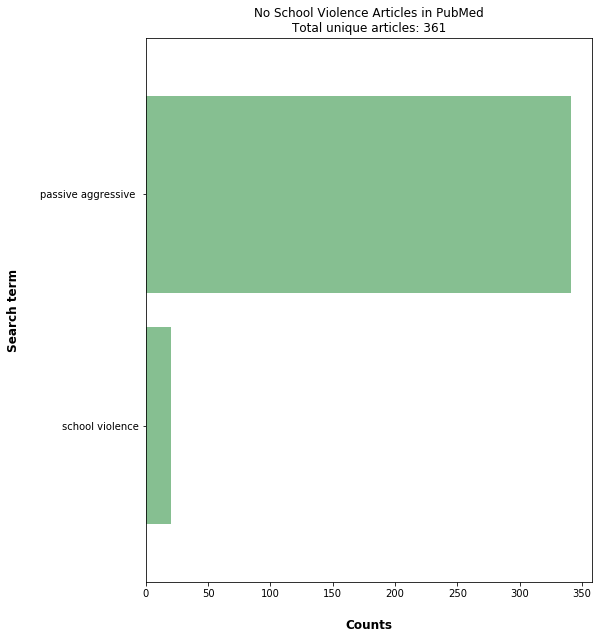

Entries in table searchterms: 361
Index(['pmid', 'searchterm'], dtype='object')
[(213573, 'passive aggressive '), (259410, 'passive aggressive '), (289528, 'passive aggressive '), (472838, 'passive aggressive '), (511995, 'passive aggressive ')]
Entries in table pubmeddata: 361
Index(['pmid', 'pubmedarticleset', 'pubmedarticle', 'medlinecitation',
       'daterevised', 'year', 'month', 'day', 'article', 'journal', 'issn',
       'journalissue', 'pubdate', 'title', 'isoabbreviation', 'articletitle',
       'elocationid', 'abstract', 'abstracttext', 'authorlist', 'author',
       'lastname', 'forename', 'initials', 'affiliationinfo', 'affiliation',
       'language', 'publicationtypelist', 'publicationtype', 'articledate',
       'medlinejournalinfo', 'country', 'medlineta', 'nlmuniqueid',
       'issnlinking', 'pubmeddata', 'history', 'pubmedpubdate', 'hour',
       'minute', 'publicationstatus', 'articleidlist', 'articleid'],
      dtype='object')
[(213573, '', '', '', '', 1978, 3, 1, 

In [ ]:
# Term to be searched in pubmed
searchterm = 'school violence'
# Number of return items
numitems = 10 
debug = False
runexamples=False
pm = PubMedDownloader(debug=debug)
if runexamples:
    pm._display_db_tables()
    pm.search_entrez(searchterm)
    pm.search_page(searchterm)
    pm.download_entrez_summary(30439779)
    pm.get_abstract(30439779)
    pm.clean_xml_abstract_page(30439779)
else:
    pm.run_all_kws()

# BaseDownloader

This class downloads a general pdf file from the following url.  Still need to implement pdf parsing.

In [ ]:
class BaseDownloader(object):
    
    def __init__(self):
        # load the websites to scrape
        self.df = pd.read_csv('./data/privacy_url_companies-clean-original.csv')
    
    def download_pdf(self, url):
        """Download pdf and save it to a file."""
        
        #page = urllib.request.urlopen('https://journals.sagepub.com/doi/pdf/10.1177/2158244017700460')
        page = requests.get(url)
        with open('./data/pdf/temp.pdf', 'wb') as f:
            f.write(page.content)
            
    def download_page(self, url):
        """Download specific page for parsing."""

        page = urllib.request.urlopen(url)
        # parse the page
        parser = BeautifulSoup(page,'html.parser')
        print(parser)
        #print(parser.find_all('meta'))
        randnum = random.randint(1,5) 
        time.sleep(randnum)
            
    def _download_urls(self, url):
        """Download urls based on specific url"""
        
        for url in self.df['url']:
            self.download_page(url)
        

        

In [ ]:
bd = BaseDownloader()
bd.download_pdf('https://journals.sagepub.com/doi/pdf/10.1177/2158244017700460')

## General Resources that Might Be of Relevance

### NCES crime indicators at schools
https://nces.ed.gov/programs/crimeindicators/ind_06.asp 